# Augmentation

In [1]:
from __future__ import division
import os
import json
import torch
from maskrcnn_benchmark.structures.bounding_box import BoxList
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pprint import pprint
from maskrcnn_benchmark.structures.segmentation_mask import SegmentationMask

import torch
import math
import random
from PIL import Image, ImageOps, ImageEnhance, PILLOW_VERSION
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections
import warnings

import torchvision.transforms.functional as transforms
from skimage.color import grey2rgb

'''
from maskrcnn_benchmark.data.transforms.transforms import Resize
from maskrcnn_benchmark.data.transforms.transforms import RandomHorizontalFlip
from maskrcnn_benchmark.data.transforms.transforms import ToTensor
from maskrcnn_benchmark.data.transforms.transforms import Normalize
from maskrcnn_benchmark.data.transforms.transforms import Compose
'''
from pycocotools.coco import *
from matplotlib.patches import Rectangle
from math import sin, cos, radians
import cv2

pylab.rcParams['figure.figsize'] = 20, 12
import matplotlib.image as mpimg

In [2]:
'''img_dir = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190309_aug_pop/train/'
img = [img_dir + i for i in os.listdir(img_dir)]
for i in img:
    isd = mpimg.imread(i)
    plt.imshow(isd)
    plt.axis('off')
    plt.show()'''

"img_dir = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190309_aug_pop/train/'\nimg = [img_dir + i for i in os.listdir(img_dir)]\nfor i in img:\n    isd = mpimg.imread(i)\n    plt.imshow(isd)\n    plt.axis('off')\n    plt.show()"

In [3]:
class Box(BoxList):
    def transpose(self, method):
        """
        Transpose bounding box (flip or rotate in 90 degree steps)
        :param method: One of :py:attr:`PIL.Image.FLIP_LEFT_RIGHT`,
          :py:attr:`PIL.Image.FLIP_TOP_BOTTOM`, :py:attr:`PIL.Image.ROTATE_90`,
          :py:attr:`PIL.Image.ROTATE_180`, :py:attr:`PIL.Image.ROTATE_270`,
          :py:attr:`PIL.Image.TRANSPOSE` or :py:attr:`PIL.Image.TRANSVERSE`.
        """
        if method not in (FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90):
            raise NotImplementedError(
                "Only FLIP_LEFT_RIGHT and FLIP_TOP_BOTTOM implemented"
            )

        image_width, image_height = self.size
        xmin, ymin, xmax, ymax = self._split_into_xyxy()
        if method == FLIP_LEFT_RIGHT:
            TO_REMOVE = 1
            transposed_xmin = image_width - xmax - TO_REMOVE
            transposed_xmax = image_width - xmin - TO_REMOVE
            transposed_ymin = ymin
            transposed_ymax = ymax
        elif method == FLIP_TOP_BOTTOM:
            transposed_xmin = xmin
            transposed_xmax = xmax
            transposed_ymin = image_height - ymax
            transposed_ymax = image_height - ymin
        
        # own to rotate of 90 degrees
        elif method == ROTATE_90:
            angle_rad = radians(90 % 360)
            transposed_xmax = image_width - xmax
            transposed_xmin = image_width - xmin
            
            transposed_ymax = transposed_xmax
            transposed_ymin = transposed_xmin
            transposed_xmax = ymax
            transposed_xmin = ymin

        transposed_boxes = torch.cat(
            (transposed_xmin, transposed_ymin, transposed_xmax, transposed_ymax), dim=-1
        )
        bbox = BoxList(transposed_boxes, self.size, mode="xyxy")
        # bbox._copy_extra_fields(self)
        for k, v in self.extra_fields.items():
            if not isinstance(v, torch.Tensor):
                v = v.transpose(method)
            bbox.add_field(k, v)
        return bbox.convert(self.mode)

In [4]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string


class Resize(object):
    def __init__(self, min_size, max_size):
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)
        self.min_size = min_size
        self.max_size = max_size

    # modified from torchvision to add support for max size
    def get_size(self, image_size):
        w, h = image_size
        size = random.choice(self.min_size)
        max_size = self.max_size
        if max_size is not None:
            min_original_size = float(min((w, h)))
            max_original_size = float(max((w, h)))
            if max_original_size / min_original_size * size > max_size:
                size = int(round(max_size * min_original_size / max_original_size))

        if (w <= h and w == size) or (h <= w and h == size):
            return (h, w)

        if w < h:
            ow = size
            oh = int(size * h / w)
        else:
            oh = size
            ow = int(size * w / h)

        return (oh, ow)

    def __call__(self, image, target):
        size = self.get_size(image.size)
        image = transforms.resize(image, size)
        target = target.resize(image.size)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            image = transforms.hflip(image)
            target = target.transpose(0)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        return transforms.to_tensor(image), target


class Normalize(object):
    def __init__(self, mean, std, to_bgr255=True):
        self.mean = mean
        self.std = std
        self.to_bgr255 = to_bgr255

    def __call__(self, image, target):
        if self.to_bgr255:
            image = image[[2, 1, 0]] * 255
        image = transforms.normalize(image, mean=self.mean, std=self.std)
        return image, target


In [5]:
# own transformation classes

class VerticalFlip(object):
    def __init__(self, prob = 0.5):
        self.prob = prob
    def __call__(self, image, target):
        if random.random() < self.prob:
            image = transforms.vflip(image)
            target = target.transpose(1)
        return image, target

class Rotate(object):
    def __init__(self, prob = 0.5):
        self.prob = prob
    def __call__(self, image, target):
        if random.random() < self.prob:
            angle = random.choice([90, 180, 270])
            print(angle)
            image = transforms.rotate(image, angle)
            if angle == 90:
                target = target.transpose(2)
            elif angle == 270:
                target = target.transpose(3)
            elif angle == 180:
                target = target.transpose(4)
        return image, target

In [6]:
def show_instances(img, target):
    plt.imshow(img); plt.axis("off")
    ax = plt.gca()
    color = []
    polygons = []
    
    polys = (vars(target)['extra_fields']['masks'])
    for b in polys:
        tenso = vars(b)['polygons'][0]
    
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        poly1 = tenso.numpy()
        poly = poly1.reshape((int(len(poly1)/2),2))
        polygons.append(Polygon(poly))
        color.append(c)

    p = PatchCollection(polygons, facecolor = 'none', linewidths = 0, alpha = 0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor = 'none', edgecolors = color, linewidths = 2)
    ax.add_collection(p)
    plt.show()

In [7]:
def make_transform(img, target, mean_std = ([0., 0., 0.], [1., 1., 1.]),
                   to_bgr255 = True, 
                   hflip_prob = 0, vflip_prob = 0, 
                   rot_prob = 0):

    max_size = max(img.size)
    min_size = max(img.size)
    
    resi = Resize(min_size, max_size)
    hori_flip = RandomHorizontalFlip(prob = hflip_prob)
    toten = ToTensor()
    norm = Normalize(mean_std[0], mean_std[1], to_bgr255)

    # own
    rot = Rotate(prob = rot_prob)
    veri_flip = VerticalFlip(prob = vflip_prob)
    
    transform = Compose([resi, hori_flip, veri_flip, rot,
                         toten, norm])
    new_img, new_target = transform(img, target)
    
    img_array = np.transpose(new_img.numpy(), (1, 2, 0))
    cv2.imwrite('pic.jpeg', img_array)
    show_image = mpimg.imread('pic.jpeg')
    show_instances(show_image, new_target)    
    

In [8]:
def getitem_coco(image, ann_file, mean_std = ([0., 0., 0.],[1., 1., 1.]), 
                 hflip_prob = 0, vflip_prob = 0, rotation_angle = 0):
    
    data = json.load(open(ann_file))
    coco = COCO(ann_file)
    anno = [obj for obj in data['annotations'] if obj['iscrowd'] == 0]
    
    # boxes
    boxes = [obj['bbox'] for obj in anno]
    boxes = torch.as_tensor(boxes).reshape(-1,4)
    
    img = Image.open(image)
    target = Box(boxes, img.size, mode = 'xywh').convert('xyxy')
    
    classes = [obj['category_id'] for obj in data['annotations']]
    
    json_category_id_to_contiguous_id = {
            v: i + 1 for i, v in enumerate(coco.getCatIds())
    }
    classes = [json_category_id_to_contiguous_id[c] for c in classes]
    classes = torch.tensor(classes)

    target.add_field('labels', classes)

    masks = [obj["segmentation"] for obj in anno]
    masks = SegmentationMask(masks, img.size)
    target.add_field("masks", masks)
    target = target.clip_to_image(remove_empty=True)
    
    
    # original image
    show_instances(img, target)   
    
    for i in range(8):
        make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 0, rot_prob = 1)
    
    
    '''
    make_transform(img, target, mean_std = mean_std, hflip_prob = 1, vflip_prob = 0, rotation_angle = 0)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 1, vflip_prob = 1, rotation_angle = 0)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 1, rotation_angle = 0)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 0, rotation_angle = 270)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 0, rotation_angle = 90)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 1, rotation_angle = 270)
    make_transform(img, target, mean_std = mean_std, hflip_prob = 0, vflip_prob = 1, rotation_angle = 90)
    '''

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


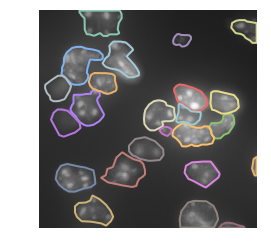

270


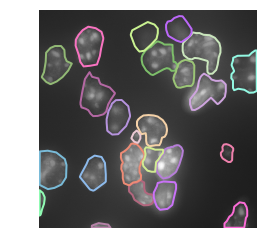

90


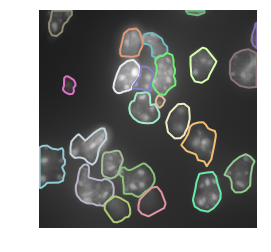

180


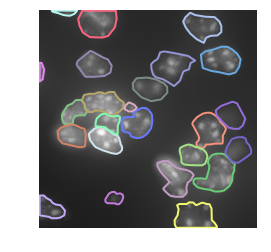

180


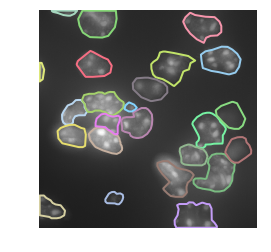

90


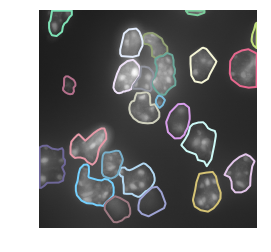

270


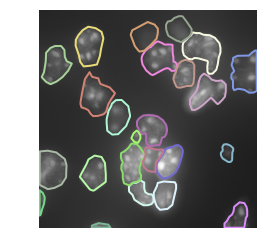

180


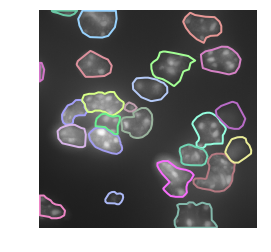

90


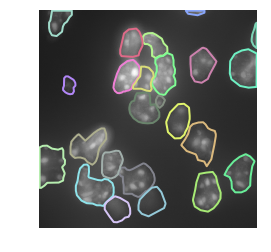

In [9]:
getitem_coco('/home/max/github/ms2/test_augmentation/Raw_Nuclei_510.png', 
             '/home/max/github/ms2/test_augmentation/testing_raw_510.json', 
             hflip_prob = 0, vflip_prob = 0, rotation_angle = 0)


In [ ]:
import random
cases = [i for i in range(1,8)]
i = random.choice(cases)